## functions

In [12]:
import pandas as pd
import numpy as np
import os
import gc

import addict
import lightgbm as lgb

def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)


def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)


def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)


def load_dataframe32(path, nrows=None):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    if nrows and nrows > 0:
        return result.head(nrows)
    return result

In [3]:
from sklearn.metrics import roc_auc_score

In [4]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.optimizers import  Adam, Nadam

from string import punctuation
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import numpy as np

C:\Anaconda2\envs\python3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import sys
import time
import lightgbm as lgb

from bayes_opt import BayesianOptimization
from scipy.stats import pearsonr


import warnings
import lightgbm as lgb

warnings.filterwarnings("ignore")

## feature group & model structure

In [6]:
def get_header(feature_name, length=4):
    for char in "0123456789":
        feature_name = feature_name.replace(char, "")
    items = feature_name.split("_")
    if len(items) < length + 1:
        return "short"
    return "_".join(items[:length])

def create_feature_info(features):
    features_info = pd.DataFrame({
        "feature_idx": np.arange(len(features)),
        "feature_name": features
    })

    features_info["feature_header"] = features_info.feature_name.apply(get_header)
    features_info["group_size"] = features_info.feature_header.map(features_info.feature_header.value_counts())
    features_info.loc[features_info.group_size < 10, "feature_header"] = "short"
    features_info["group_size"] = features_info.feature_header.map(features_info.feature_header.value_counts())
    return features_info

In [7]:
def create_scaler_stack(features_info):
    return {key: StandardScaler() for key in features_info.feature_header.unique()}

def create_feature_stack(feature_info):
    return {key: list(features_info[features_info.feature_header == key].feature_name) for key in features_info.feature_header.unique()}

def replace_nan(X):
    X = X.copy()
    X[np.isnan(X)] = 0
    X[X == np.Inf] = X[X != np.Inf].max()
    X[X == -np.Inf] = X[X != -np.Inf].min()
    # print(X.shape, X.max(), X.min())
    return X

In [8]:
def less_ftr(input_dim):
    return int(np.log(input_dim) * np.sqrt(input_dim))

def create_model(feature_stack):
    input_lyr = [Input(shape=[len(ftrs_)], name=key_) for key_, ftrs_ in feature_stack.items()]
    dense0_lyr = [Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i]) for i, (key_, ftrs_) in enumerate(feature_stack.items())]
    main0_lyr = concatenate(dense0_lyr)
    drop0_lyr = Dropout(.6)(main0_lyr)
    main1_lyr = Dense(128, activation="relu")(drop0_lyr)
    output = Dense(1, activation="sigmoid")(main1_lyr)
    model = Model(input_lyr, output)
    model.compile(loss="binary_crossentropy", optimizer="adam")
    return model


def create_model(feature_stack):
    input_lyr = [Input(shape=[len(ftrs_)], name=key_) for key_, ftrs_ in feature_stack.items()]
    dense0_lyr = [Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i]) for i, (key_, ftrs_) in enumerate(feature_stack.items())]
    
    input_cct64_lyr = concatenate(input_lyr)
    drop0_cct64_lyr = Dropout(.65)(input_cct64_lyr)
    dense0_cct64_lyr = Dense(64, activation="relu")(drop0_cct64_lyr)
    
    input_cct32_lyr = concatenate(input_lyr)
    drop0_cct32_lyr = Dropout(.65)(input_cct32_lyr)
    dense0_cct32_lyr = Dense(32, activation="relu")(drop0_cct32_lyr)

    input_cct16_lyr = concatenate(input_lyr)
    drop0_cct16_lyr = Dropout(.65)(input_cct16_lyr)
    dense0_cct16_lyr = Dense(16, activation="relu")(drop0_cct16_lyr)

    input_cct8_lyr = concatenate(input_lyr)
    drop0_cct8_lyr = Dropout(.65)(input_cct8_lyr)
    dense0_cct8_lyr = Dense(8, activation="relu")(drop0_cct8_lyr)
    
    main0_lyr = concatenate(dense0_lyr)
    drop0_lyr = Dropout(.65)(main0_lyr)
    main1_lyr = Dense(128, activation="relu")(drop0_lyr)
    
    merge_lyr = concatenate([main1_lyr, dense0_cct64_lyr, dense0_cct32_lyr, dense0_cct16_lyr, dense0_cct8_lyr])
    drop1_lyr = Dropout(.2)(merge_lyr)
    output = Dense(1, activation="sigmoid")(drop1_lyr)

    model = Model(input_lyr, output)
    # opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.9)
    # opt = Adam(lr=0.0000001, beta_1=0.9, beta_2=0.999)
    # opt = Nadam(lr=0.00002, beta_1=0.9, beta_2=0.999)
    opt = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

from functools import partial

features = list(np.load('./neptune-features/features_246008_1174_0.npy'))
features_info = create_feature_info(features)
features_stack = create_feature_stack(features_info)
create_model_fixed = partial(create_model, features_stack)

In [9]:
features = list(np.load('./neptune-features/features_246008_1174_0.npy'))
features_info = create_feature_info(features)
features_stack = create_feature_stack(features_info)

model = create_model(features_stack)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
short (InputLayer)              (None, 226)          0                                            
__________________________________________________________________________________________________
NAME_EDUCATION_TYPE_CODE (Input (None, 90)           0                                            
__________________________________________________________________________________________________
NAME_FAMILY_STATUS_NAME (InputL (None, 90)           0                                            
__________________________________________________________________________________________________
NAME_FAMILY_STATUS_CODE (InputL (None, 90)           0                                            
__________________________________________________________________________________________________
NAME_EDUCA

## early stop

In [13]:
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from keras.wrappers.scikit_learn import KerasClassifier

In [14]:
class roc_auc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        # y_pred = self.model.predict_proba(self.x, verbose=0)
        y_pred = self.model.predict(self.x, verbose=0)
        roc = roc_auc_score(self.y, y_pred)
        logs['roc_auc'] = roc_auc_score(self.y, y_pred)
        logs['norm_gini'] = ( roc_auc_score(self.y, y_pred) * 2 ) - 1

        # y_pred_val = self.model.predict_proba(self.x_val, verbose=0)
        y_pred_val = self.model.predict(self.x_val, verbose=0)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        logs['roc_auc_val'] = roc_auc_score(self.y_val, y_pred_val)
        logs['norm_gini_val'] = ( roc_auc_score(self.y_val, y_pred_val) * 2 ) - 1

        # print('\rroc_auc: %s - roc_auc_val: %s - norm_gini: %s - norm_gini_val: %s' % (str(round(roc,5)),str(round(roc_val,5)),str(round((roc*2-1),5)),str(round((roc_val*2-1),5))), end=10*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

## keras

In [15]:
nrows = 1000
nrows = 10000
nrows = None

features = list(np.load('./neptune-features/features_246008_1174_0.npy'))
features_info = create_feature_info(features)
features_stack = create_feature_stack(features_info)

train_app = load_dataframe32("./bindata/application_train")
auc_valid_stack = []
pred_valid_stack = []
pred_test_stack = []

run = 4
for i in range(5):
    train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
    valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

    train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3
    
    train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
    valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
    test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)
    
    if i == 0:
        train_data_fn = train_data_fn.replace("246009", "246008")
        valid_data_fn = valid_data_fn.replace("61502", "61503")
    
    gc.collect()

    train_idx = np.load(train_idx_fn)
    valid_idx = np.load(valid_idx_fn)
    
    if nrows:
        train_idx, valid_idx = train_idx[:nrows].copy(), valid_idx[:nrows].copy()

    train_data = load_dataframe32(train_data_fn, nrows)
    valid_data = load_dataframe32(valid_data_fn, nrows)
    test_data = load_dataframe32(test_data_fn, nrows)
    gc.collect()
    

    print(train_idx_fn, valid_idx_fn)
    print(train_idx.shape, valid_idx.shape)
    print(train_data_fn, train_data.shape)
    print(valid_data_fn, valid_data.shape)
    print(test_data_fn, test_data.shape)

    scalar_stack = create_scaler_stack(features_info)
    X_train_mult = {key: scalar_stack[key].fit_transform(replace_nan(train_data[items].values)) for key, items in features_stack.items()}
    X_valid_mult = {key: scalar_stack[key].transform(replace_nan(valid_data[items].values)) for key, items in features_stack.items()}
    X_test_mult = {key: scalar_stack[key].transform(replace_nan(test_data[items].values)) for key, items in features_stack.items()}

    y_train = train_app.loc[train_idx].TARGET
    y_valid = train_app.loc[valid_idx].TARGET
    gc.collect()
    
    check_point_fn = '038-keras-5fold-run-{}-v1-fold-'.format(run) + str('%02d' % (i + 1)) + '-run-' + str('%02d' % (run + 1)) + '.check'
    log_fn = 'keras038-5fold-run-{}-v1-epoch-fold-{}.log'.format(run, i + 1)
    
    callbacks = [
        roc_auc_callback(
            training_data=(X_train_mult, y_train),
            validation_data=(X_valid_mult, y_valid)
        ),  # call this before EarlyStopping
        EarlyStopping(monitor='norm_gini_val', patience=50, mode='max', verbose=1),
        CSVLogger(log_fn, separator=',', append=False),
        ModelCheckpoint(
            check_point_fn,
            monitor='norm_gini_val', mode='max', # mode must be set to max or Keras will be confused
            save_best_only=True,
            verbose=0
        )
    ]

    np.random.seed(i)
    # create_model(features_stack)
    estimator = KerasClassifier(
        build_fn=create_model_fixed,
        epochs=5000,
        batch_size=500, # 500
        validation_data=(X_valid_mult, y_valid),
        verbose=0,
        shuffle=True,
        callbacks=callbacks
    )
    %time estimator.fit(X_train_mult, y_train)
    
    del estimator
    estimator = load_model(check_point_fn)
    
    pred_valid = estimator.predict(X_valid_mult)
    pred_valid_stack.append(pred_valid)
    
    auc = roc_auc_score(y_valid, pred_valid)
    auc_valid_stack.append(auc)
    print("fold-{},auc:{}".format(i, auc))

    pred_test = estimator.predict(X_test_mult)
    pred_test_stack.append(pred_test)
    
print("kfold-auc, avg:{:.4}, std:{:.2}".format(np.mean(auc_valid_stack), np.std(auc_valid_stack)))

./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(246008,) (61503,)
./neptune-features/data_246008_1174_0 (246008, 1174)
./neptune-features/data_61503_1174_1 (61503, 1174)
./neptune-features/data_48744_1174_3 (48744, 1174)
Epoch 00125: early stopping
Wall time: 2h 15min 57s
fold-0,auc:0.7873412411768296
./neptune-features/train_idx_1.npy ./neptune-features/valid_idx_1.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_4 (246009, 1174)
./neptune-features/data_61502_1174_5 (61502, 1174)
./neptune-features/data_48744_1174_7 (48744, 1174)
Epoch 00122: early stopping
Wall time: 2h 15min 51s
fold-1,auc:0.7804052478996679
./neptune-features/train_idx_2.npy ./neptune-features/valid_idx_2.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_8 (246009, 1174)
./neptune-features/data_61502_1174_9 (61502, 1174)
./neptune-features/data_48744_1174_11 (48744, 1174)
Epoch 00134: early stopping
Wall time: 2h 34min 58s
fold-2,auc:0.7801276106454434
./neptune-features/tr

## learning curve

opt = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999)
auc = 0.7482156911494797


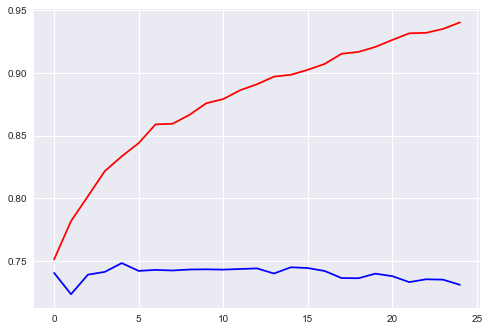

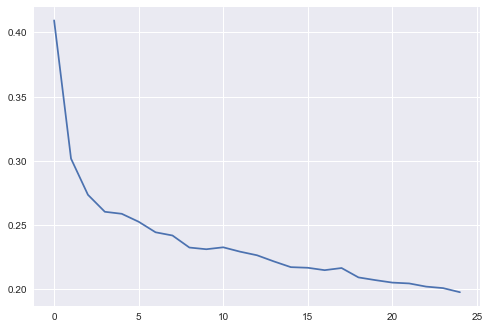

In [59]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log")
log = log36

print("opt = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999)")
print("auc = 0.7482156911494797")
plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

plt.plot(log.epoch, log.loss)
plt.show()

opt = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999)
auc = 0.0.7457370445268262


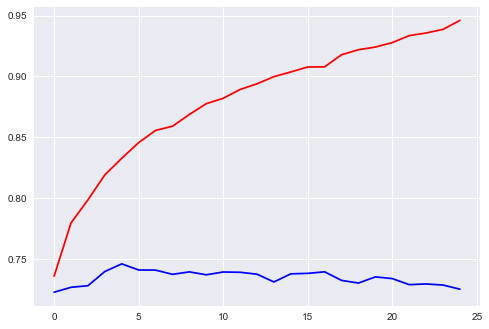

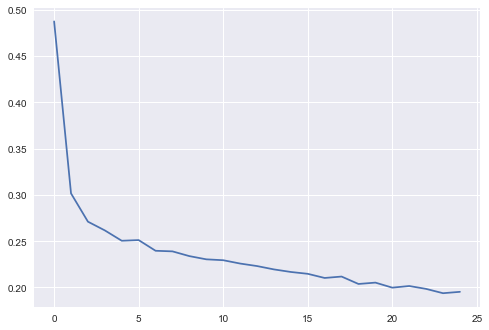

In [54]:
log38 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log")
log = log38

print("opt = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999)")
print("auc = 0.0.7457370445268262")
plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

plt.plot(log.epoch, log.loss)
plt.show()

opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
auc = 0.458891350489937


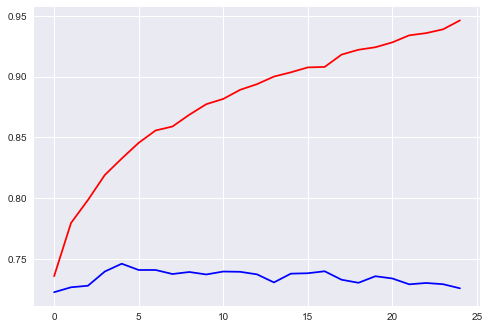

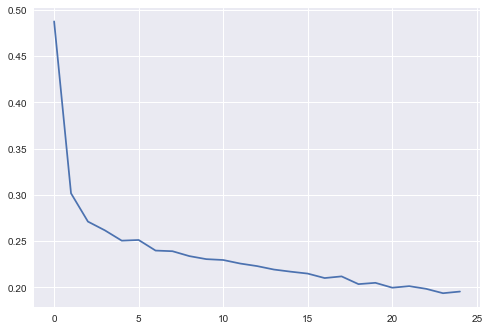

In [50]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log")
log = log36

print("opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)")
print("auc = 0.7458891350489937")
plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

plt.plot(log.epoch, log.loss)
plt.show()

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.9)
auc = 0.7457381662356666


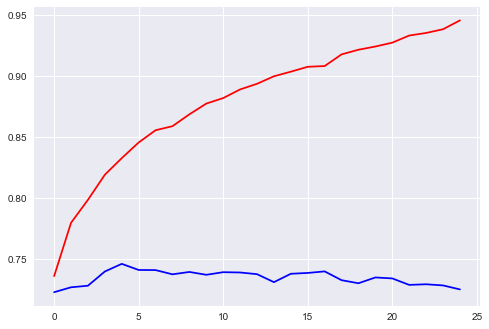

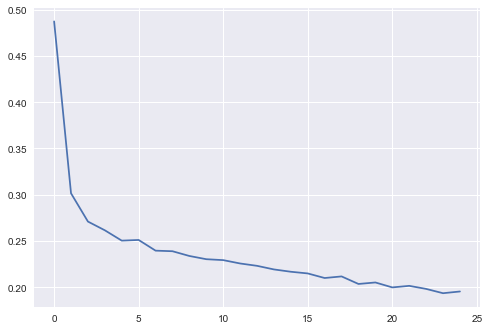

In [46]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log")
log = log36

print("opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)")
print("auc = 0.7457368465782074")
plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

plt.plot(log.epoch, log.loss)
plt.show()

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.9)
auc = 0.7457381662356666


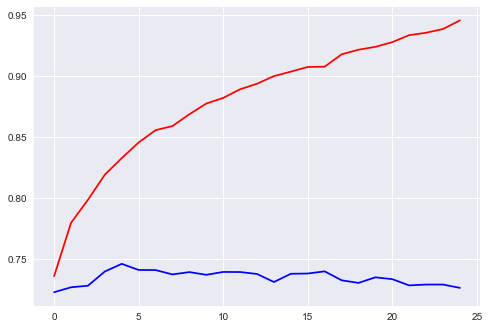

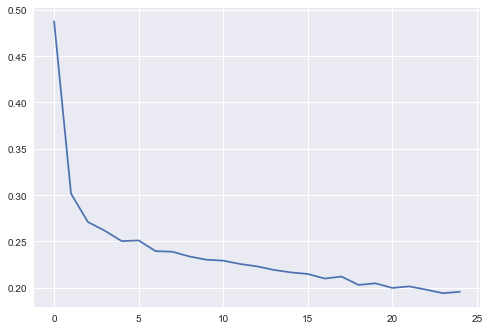

In [40]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log")
log = log36

print("opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.9)")
print("auc = 0.7457381662356666")
plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

plt.plot(log.epoch, log.loss)
plt.show()

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.9)
auc = 0.7457381662356666


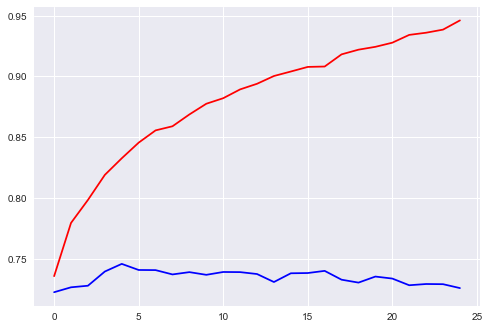

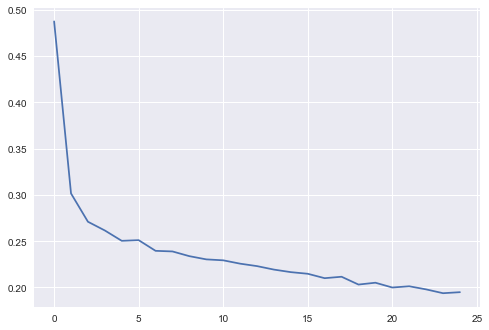

In [38]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log")
log = log36

print("opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.9)")
print("auc = 0.7457381662356666")
plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

plt.plot(log.epoch, log.loss)
plt.show()

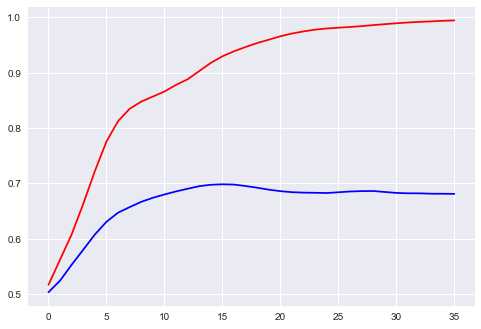

In [30]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log")
log = log36

plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

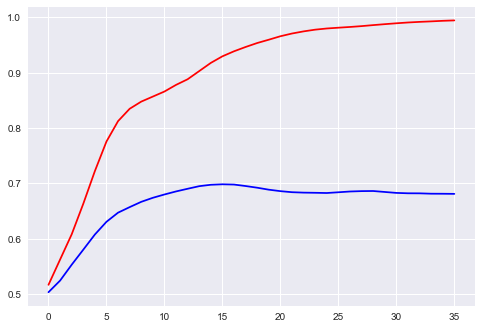

In [26]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log")
log = log36

plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

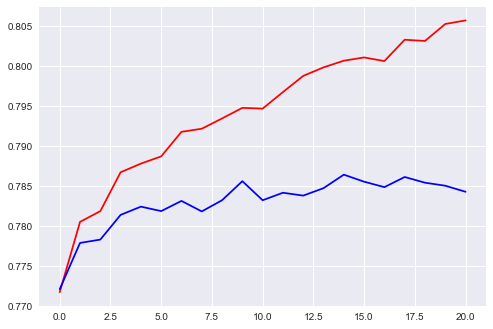

In [15]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log")
log = log36

plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.9)
auc = 0.7457381662356666


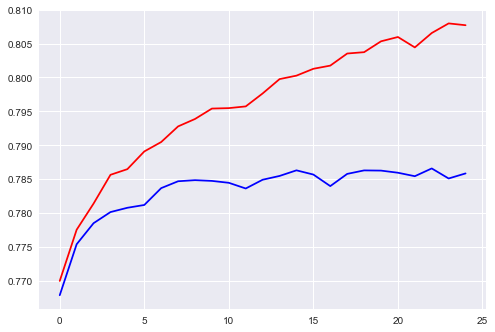

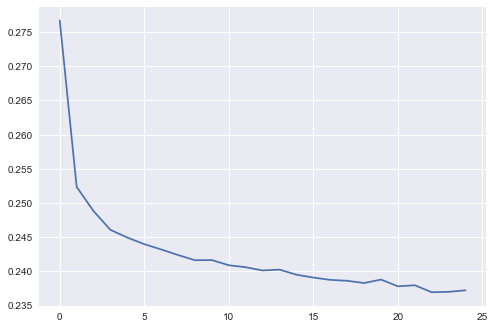

In [61]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log.backup")
log = log36

print("opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.9)")
print("auc = 0.7457381662356666")
plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

plt.plot(log.epoch, log.loss)
plt.show()

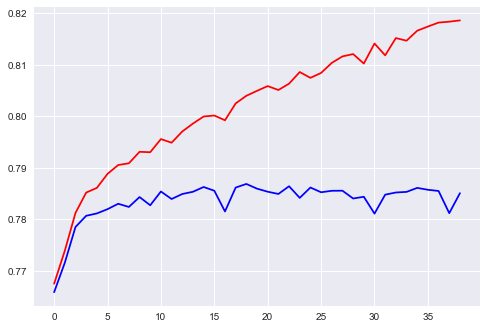

In [67]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log")
log = log36

plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

plt.plot(log.epoch, log.loss)
plt.show()

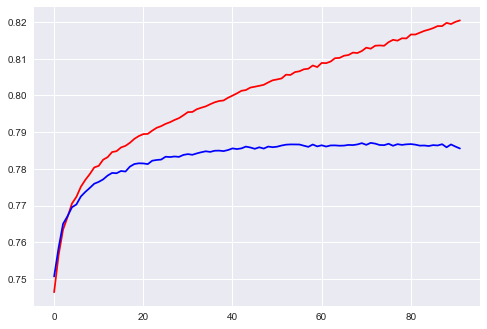

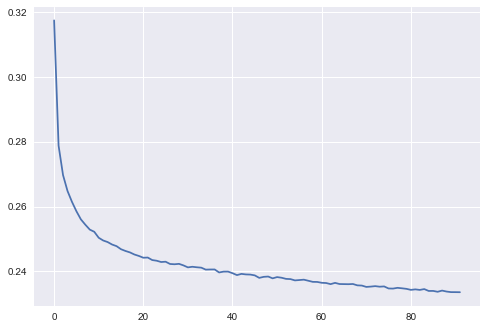

In [70]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-1.log")
log = log36

plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

plt.plot(log.epoch, log.loss)
plt.show()

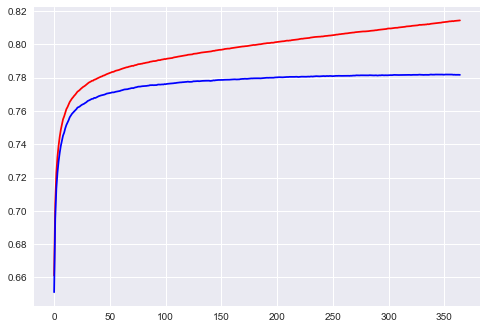

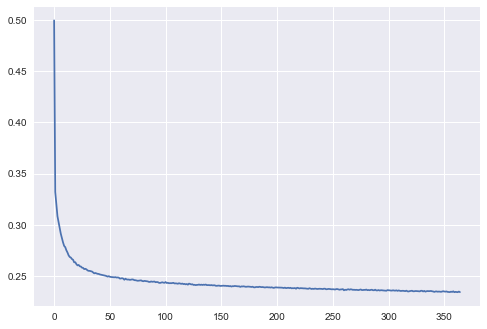

In [83]:
log36 = pd.read_csv("./keras038-5fold-run-3-v1-epoch-fold-5.log")
log = log36

plt.plot(log.epoch, log.roc_auc, c="r")
plt.plot(log.epoch, log.roc_auc_val, c="b")
plt.show()

plt.plot(log.epoch, log.loss)
plt.show()

## save oof & submission

In [18]:
def calculate_rank(predictions):
    rank = (1 + pd.Series(predictions).rank().values) / (predictions.shape[0] + 1)
    return rank

In [86]:
pred_test_stack

[array([[0.05016068],
        [0.15800135],
        [0.02343937],
        ...,
        [0.01606217],
        [0.04193696],
        [0.19432412]], dtype=float32), array([[0.06478611],
        [0.17871755],
        [0.05090065],
        ...,
        [0.01883596],
        [0.04330845],
        [0.2660742 ]], dtype=float32), array([[0.06531779],
        [0.16371636],
        [0.03275765],
        ...,
        [0.01619415],
        [0.05017608],
        [0.208277  ]], dtype=float32), array([[0.06209571],
        [0.1564854 ],
        [0.03136708],
        ...,
        [0.0152378 ],
        [0.04115357],
        [0.19500324]], dtype=float32), array([[0.05819519],
        [0.15253244],
        [0.02287433],
        ...,
        [0.01154504],
        [0.03888638],
        [0.19625895]], dtype=float32)]

In [85]:
np.save("./kfold-result/kfold-result-038-keras01.npy", pred_test_stack)

In [19]:
pred_sample = pd.read_csv("./result/submission-022-blend08.csv")
pred_target = sum([calculate_rank(p_.reshape(pred_sample.shape[0])) for p_ in pred_test_stack]) / 5

pred_sample["TARGET"] = pred_target

pred_sample.to_csv("./result/submission-038-keras01.csv", index=False)

In [20]:
oof_pred = np.zeros(train_app.shape[0])

for i in range(5):
    valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)
    valid_idx = np.load(valid_idx_fn)
    oof_pred[valid_idx] = pred_valid_stack[i].reshape(len(valid_idx))
    
oof_df = train_app[["SK_ID_CURR"]].copy()
oof_df["SK_ID_CURR"] = oof_df.SK_ID_CURR.astype("int")
oof_df["oof_pred"] = oof_pred
oof_df.to_csv("./oof-result/oof-038-keras01.csv", index=False)

In [21]:
sub025 = pd.read_csv("./result/submission-025-keras01.csv")

pred_sample["TARGET"] = pred_sample.TARGET * 0.5 + sub025.TARGET * 0.5
pred_sample.to_csv("./result/submission-038-keras01-avg-025.csv", index=False)

FileNotFoundError: File b'./result/submission-025-keras01.csv' does not exist

## average submission

In [25]:
pred_lgb024 = pd.read_csv("./result/submission-024-first.csv")
pred_keras025 = pd.read_csv("./result/submission-025-keras01.csv")
pred_bld = pd.read_csv("./result/submission-022-blend08.csv")
pred_keras_avg = pd.read_csv("./result/submission-030-keras01-avg-025.csv")

In [27]:
pred_sample["TARGET"] = calculate_rank(pred_lgb024.TARGET) * 0.8 + calculate_rank(pred_bld.TARGET) * 0.15 + calculate_rank(pred_keras_avg.TARGET) * 0.05
pred_sample.to_csv("./result/submission-030-bld-to-overfit.csv", index=False)

In [6]:
pred_lgb024 = pd.read_csv("./result/submission-024-first.csv")
pred_keras025 = pd.read_csv("./result/submission-025-keras01.csv")

pred_lgb024["TARGET"] = pred_lgb024.TARGET * 0.88 + pred_keras025.TARGET * .12

pred_lgb024.to_csv("./result/submission-025-avg-l88k12.csv", index=False)

pred_lgb024.head()

,SK_ID_CURR,TARGET
0,100001,0.465416
1,100005,0.833949
2,100013,0.330790
3,100028,0.464483
4,100038,0.861296


In [103]:
def show_oof_auc(oof_df, p_col):
    auc_valid_stack = []
    for i in range(5):
        train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
        valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

        train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3

        train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
        valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
        test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)

        if i == 0:
            train_data_fn = train_data_fn.replace("246009", "246008")
            valid_data_fn = valid_data_fn.replace("61502", "61503")

        gc.collect()

        train_idx = np.load(train_idx_fn)
        valid_idx = np.load(valid_idx_fn)

        fold_data = oof_df.loc[valid_idx]
        fold_target = fold_data.TARGET
        fold_pred = fold_data[p_col]

        auc = roc_auc_score(fold_target, fold_pred)
        auc_valid_stack.append(auc)
        print("fold-{},auc:{}".format(i, auc))

    print("kfold-auc, avg:{:.4}, std:{:.2}".format(np.mean(auc_valid_stack), np.std(auc_valid_stack)))

In [105]:
oof_lgb024 = pd.read_csv("./oof-result/oof-024-first.csv")
oof_lgb024["oof_keras"] = oof_pred
oof_lgb024["TARGET"] = train_app.TARGET

oof_lgb024["mix_55"] = oof_lgb024.oof_keras * .5 + oof_lgb024.oof_pred * .5

oof_lgb024.head()

,SK_ID_CURR,oof_pred,oof_keras,TARGET,mix_55
0,100002,0.316064,0.278892,1.0,0.297478
1,100003,0.019087,0.015010,0.0,0.017049
2,100004,0.041876,0.067596,0.0,0.054736
3,100006,0.033489,0.043004,0.0,0.038246
4,100007,0.040865,0.076490,0.0,0.058677


In [104]:
show_oof_auc(oof_lgb024, "oof_pred")
show_oof_auc(oof_lgb024, "oof_keras")

fold-0,auc:0.7986498079146619
fold-1,auc:0.7926606538676264
fold-2,auc:0.7933782903017764
fold-3,auc:0.7949564349672997
fold-4,auc:0.7930097947068893
kfold-auc, avg:0.7945, std:0.0022
fold-0,auc:0.7866254609675846
fold-1,auc:0.7801398565450309
fold-2,auc:0.7802676912681713
fold-3,auc:0.7838391816098259
fold-4,auc:0.7811900203631054
kfold-auc, avg:0.7824, std:0.0025


In [106]:
show_oof_auc(oof_lgb024, "mix_55")

fold-0,auc:0.797128475507405
fold-1,auc:0.7909159578428271
fold-2,auc:0.7913739384564014
fold-3,auc:0.79354063441526
fold-4,auc:0.7917407133910702
kfold-auc, avg:0.7929, std:0.0023


In [107]:
oof_lgb024["mix_13"] = oof_lgb024.oof_keras * .25 + oof_lgb024.oof_pred * .75
show_oof_auc(oof_lgb024, "mix_13")

fold-0,auc:0.7988254724598242
fold-1,auc:0.7927662731929991
fold-2,auc:0.793314942931169
fold-3,auc:0.795134204461209
fold-4,auc:0.7932680469247197
kfold-auc, avg:0.7947, std:0.0022


In [108]:
oof_lgb024["mix_14"] = oof_lgb024.oof_keras * .2 + oof_lgb024.oof_pred * .7
show_oof_auc(oof_lgb024, "mix_14")

fold-0,auc:0.7988938381041268
fold-1,auc:0.7928513942183786
fold-2,auc:0.7934184461650928
fold-3,auc:0.7952020155735425
fold-4,auc:0.793326499497936
kfold-auc, avg:0.7947, std:0.0022


In [116]:
def rank_avg_and_show_oof_auc(oof_df, weight=.5):
    auc_valid_stack = []
    for i in range(5):
        train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
        valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

        train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3

        train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
        valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
        test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)

        if i == 0:
            train_data_fn = train_data_fn.replace("246009", "246008")
            valid_data_fn = valid_data_fn.replace("61502", "61503")

        gc.collect()

        train_idx = np.load(train_idx_fn)
        valid_idx = np.load(valid_idx_fn)

        fold_data = oof_df.loc[valid_idx]
        fold_target = fold_data.TARGET
        fold_lgbpred = fold_data["oof_pred"].values
        fold_keraspred = fold_data["oof_keras"].values
        
        fold_pred = calculate_rank(fold_lgbpred) * (1 - weight) + calculate_rank(fold_keraspred) * weight

        auc = roc_auc_score(fold_target, fold_pred)
        auc_valid_stack.append(auc)
        print("fold-{},auc:{}".format(i, auc))

    print("kfold-auc, avg:{:.6}, std:{:.2}".format(np.mean(auc_valid_stack), np.std(auc_valid_stack)))

In [113]:
rank_avg_and_show_oof_auc(oof_lgb024)

fold-0,auc:0.7966623006131177
fold-1,auc:0.7905569935655681
fold-2,auc:0.7908674106438083
fold-3,auc:0.7933767157017423
fold-4,auc:0.7912624410992268
kfold-auc, avg:0.7925, std:0.0023


In [114]:
for w_ in (.1, .2, .3, .4):
    print("keras weight", w_)
    rank_avg_and_show_oof_auc(oof_lgb024, w_)

keras weight 0.1
fold-0,auc:0.7989409808665611
fold-1,auc:0.7929442974016195
fold-2,auc:0.7935597095190682
fold-3,auc:0.7953012563437991
fold-4,auc:0.7933659482162142
kfold-auc, avg:0.7948, std:0.0022
keras weight 0.2
fold-0,auc:0.7988859171510703
fold-1,auc:0.792863095064108
fold-2,auc:0.7933939418973657
fold-3,auc:0.7953129322524238
fold-4,auc:0.793361721376982
kfold-auc, avg:0.7948, std:0.0022
keras weight 0.3
fold-0,auc:0.7984707769199209
fold-1,auc:0.7924290291338589
fold-2,auc:0.7928850664344951
fold-3,auc:0.7949932546022629
fold-4,auc:0.793004413635958
kfold-auc, avg:0.7944, std:0.0022
keras weight 0.4
fold-0,auc:0.797730717306333
fold-1,auc:0.7916600632323038
fold-2,auc:0.7920370552549774
fold-3,auc:0.7943449005696187
fold-4,auc:0.7923032641904014
kfold-auc, avg:0.7936, std:0.0023


In [118]:
for w_ in (.11, .12, .13, .14, .15, .16, .17, .18, .19, .2):
    print("keras weight", w_)
    rank_avg_and_show_oof_auc(oof_lgb024, w_)

keras weight 0.11
fold-0,auc:0.7989533156090654
fold-1,auc:0.7929536986900592
fold-2,auc:0.7935594369921393
fold-3,auc:0.7953181797317235
fold-4,auc:0.7933825420781133
kfold-auc, avg:0.794833, std:0.0022
keras weight 0.12
fold-0,auc:0.79895953552543
fold-1,auc:0.7929578453743122
fold-2,auc:0.7935555770845892
fold-3,auc:0.7953304256313108
fold-4,auc:0.7933967170408649
kfold-auc, avg:0.79484, std:0.0022
keras weight 0.13
fold-0,auc:0.7989660226203325
fold-1,auc:0.792957074105291
fold-2,auc:0.7935487763799165
fold-3,auc:0.7953402633190813
fold-4,auc:0.793404169672701
kfold-auc, avg:0.794843, std:0.0022
keras weight 0.14
fold-0,auc:0.7989630320018972
fold-1,auc:0.7929555956912318
fold-2,auc:0.7935387926319619
fold-3,auc:0.7953457067327742
fold-4,auc:0.7934040503308433
kfold-auc, avg:0.794841, std:0.0022
keras weight 0.15
fold-0,auc:0.7989596815830308
fold-1,auc:0.7929481715589437
fold-2,auc:0.7935228008230171
fold-3,auc:0.7953504928756383
fold-4,auc:0.7934085942275484
kfold-auc, avg:0.7948